# Лекция 13. Определение количества кластеров. DBSCAN

In [ ]:
import pandas as pd
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
#загрузка данных
laptops = pd.read_csv('/content/drive/MyDrive/Введение в ML ITHUB/lessons/data/laptop_price.csv', encoding='Windows-1251')
laptops.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
#предобработка
laptops['Weight']=laptops['Weight'].str.replace('kg','').astype('float64')
ssd=[]
hdd=[]
fs=[]
for i in laptops['Memory']:
    if 'SSD' in i:
        ssd.append(1)
        hdd.append(0)
        fs.append(0)
    elif 'HDD' in i:
        ssd.append(0)
        hdd.append(1)
        fs.append(0)
    else:
        ssd.append(0)
        hdd.append(0)
        fs.append(1)
laptops['ssd']=ssd
laptops['hdd']=hdd
laptops['fs']=fs
s = [float(re.findall(r'\d+', s)[0]) for s in laptops['Memory']]
laptops['Memory']=s
laptops['Ram']=laptops['Ram'].str.replace('GB','').astype('int32')
laptops.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ssd,hdd,fs
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128.0,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,1,0,0
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128.0,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,1
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256.0,Intel HD Graphics 620,No OS,1.86,575.00,1,0,0
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512.0,AMD Radeon Pro 455,macOS,1.83,2537.45,1,0,0
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256.0,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,1,0,0


In [ ]:
laptops=laptops[['Inches','Memory','Ram','Weight','Price_euros','ssd','hdd','fs']]

## Определение оптимального количества кластеров

способ 1 - метод локтя

Этот метод основан на наблюдении, что увеличение количества кластеров может помочь в уменьшении суммы внутрикластерной дисперсии каждого кластера. Наличие большего количества кластеров позволяет извлекать более мелкие группы объектов данных, которые более похожи друг на друга.

In [ ]:
X=laptops[['Inches','Price_euros']]
distortions=[]
for k in range(1,11):
  model = KMeans(n_clusters = k,n_init='auto')
  model.fit(X)
  distortions.append(sum(np.min(cdist(X,model.cluster_centers_,'euclidean'), axis = 1)) / X.shape [0])

In [ ]:
fig = px.line(x=list(range(1,11)), y=distortions)
fig.show()

способ 2 - анализ силуета (silhouette_score)

Анализ силуэта можно использовать для изучения разделительного расстояния между результирующими кластерами. График силуэта отображает меру того, насколько близко каждая точка в одном кластере находится к точкам в соседних кластерах, и, таким образом, обеспечивает способ визуальной оценки таких параметров, как количество кластеров. Эта мера имеет диапазон [-1, 1].

In [ ]:
silhouette_scores=[]
for k in range(2,11):
  model = KMeans(n_clusters = k,n_init='auto')
  model.fit(X)
  clusters = model.predict(X)
  print(k,'--',silhouette_score(X,clusters))

2 -- 0.622209094181361
3 -- 0.577356533380208
4 -- 0.5694122338252232
5 -- 0.5627717445165407
6 -- 0.5436979756212719
7 -- 0.5324993771785841
8 -- 0.5367577759123081
9 -- 0.5277337806002138
10 -- 0.5389196439630274


максимальное значение метрики - оптимальное количество кластеров


## Иерархическая кластеризация

Иерархическая кластеризация, как следует из названия, представляет собой алгоритм, который строит иерархию кластеров. Этот алгоритм начинает работу с того, что каждому экземпляру данных сопоставляется свой собственный кластер. Затем два ближайших кластера объединяются в один и так далее, пока не будет образован один общий кластер.

Результат иерархической кластеризации может быть представлен с помощью дендрограммы.

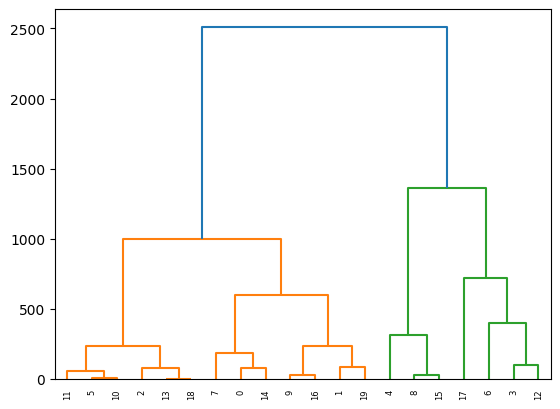

In [ ]:
import matplotlib.pyplot as plt

mergings = linkage(X[:20], method='complete')

# Строим дендрограмму, указав параметры удобные для отображения
dendrogram(mergings,
           labels=X.index[:20],
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()

## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise, плотностной алгоритм пространственной кластеризации с присутствием шума) – популярный алгоритм кластеризации, используемый в анализе данных в качестве одной из замен метода k-средних.

Метод не требует предварительных предположений о числе кластеров, но нужно настроить два других параметра: eps и min_samples. Данные параметры – это соответственно максимальное расстояние между соседними точками и минимальное число точек в окрестности (количество соседей), когда можно говорить, что эти экземпляры данных образуют один кластер. В scikit-learn есть соответствующие значения параметров по умолчанию, но, как правило, их приходится настраивать самостоятельно.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

dbscan = DBSCAN()

dbscan.fit(X[:20])
clusters = model.predict(X[:20])
print(clusters)
fig = px.scatter(x=X['Price_euros'][:20], y=X['Inches'][:20],color=clusters)
fig.update_traces(marker=dict(size=25))
fig.show()

[0 6 1 2 8 9 5 3 0 6 9 9 2 9 3 0 1 2 1 6]


предложения по тюнингу DBSCAN?

ЛАБОРАТОРНАЯ РАБОТА - КЛАСТЕРИЗАЦИЯ

* критерии к данным аналогичны прошлым лабораторным
* выполнить кластеризацию на двух признаках с использованием не менее двух различных алгоритмов
* каждый результат кластеризации визуализировать
* в конце сделать PCA по всем признакам - сжать все признаки до 2-х
* определить оптимальное количество кластеров - любым из методов
* выполнить кластеризацию - любым алгоритмом - результат визуализировать